# **Desafio IHM Stefanini - 06 - LSTM**

Será feito um modelo de regressão utilizando a biblioteca Keras para prever variável `% Silica Concentrate`. Serão feitos 5 modelos:
1. Modelo com todas as variáveis;
2. Modelo apenas com as variáveis selecionados na etapa de preparação;
3. Modelo com todas as variáveis, mas excluindo a variável `% Iron Concentrate`;
4. Modelo apenas com as variáveis selecionados na etapa de preparação e excluindo a variável `% Iron Concentrate`;

## **Carregando as bibliotecas**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, LSTM

D:\Python_Venvs\keras\vienv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Configurações do notebook**

In [2]:
%matplotlib inline
sns.set(style='white')
pd.set_option('display.max_columns', None) # Apenas se precisar
#pd.set_option('display.max_rows', None) # Apenas se precisar
#pd.options.display.float_format = '{:.2f}'.format # Suprimindo notação científica e exibindo duas casas decimais
RANDOM_SEED = 1
keras.utils.set_random_seed(RANDOM_SEED)

## **Carregando os dados**

In [3]:
df = pd.read_csv("dados_ihm_stefanini/MiningProcess_Flotation_Plant_Database.csv", decimal=",")

In [4]:
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## **Funções**

In [5]:
# Métricas
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['R2'] = r2_score(y_true, y_pred)
    metrics_dict['MSE'] = mean_squared_error(y_true, y_pred)
    metrics_dict['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    return metrics_dict

In [6]:
# Normalização (MinMax) da variável objetivo
def normY(y):
    y_max = y.max()
    y_min = y.min()
    y_norm = (y - y_min) / (y_max - y_min)

    return y_norm, y_max, y_min

# Desfaz a normalização (MinMax) da variável objetivo
def inverse_normY(y_norm, y_max, y_min):
    y_inv = y_norm * (y_max - y_min) + y_min

    return y_inv

## **Removendo as colunas que não serão utilizadas**

Será removida apenas a coluna: `date`.

In [7]:
df.drop(columns=['date'], inplace=True)

## **Construção dos modelos**

### **Modelo LSTM com todas as variáveis**

#### **Separação dos dados em teste e treino**

In [8]:
X = df.drop(columns=['% Silica Concentrate'])
y = df['% Silica Concentrate']

In [9]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [10]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [11]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [12]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [13]:
def objective(trial):    
    ## LSTM ##
    # units
    units = trial.suggest_categorical('units', [8, 16, 32, 64, 128])

    # kernel_initializer
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ["RandomNormal", "RandomUniform", "Zeros", "Ones", "GlorotNormal", "GlorotUniform"])

    # activation
    activation_lstm = trial.suggest_categorical('activation_lstm', ["relu", "linear", "sigmoid", "tanh"])

    ## Dropout ##
    # rate
    rate = trial.suggest_float('rate', 0.0001, 1)
    
    ## Dense ##
    # activation
    activation_dense = trial.suggest_categorical('activation_dense', ["relu", "linear", "sigmoid", "tanh"])

    # Instanciando o modelo
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units, kernel_initializer=kernel_initializer, activation=activation_lstm))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(units=1, activation=activation_dense))
    model.compile(loss="mse", optimizer="adam")

    # Treinando o modelo
    model.fit(X_train, y_train_norm, validation_split=0.1, batch_size=16, epochs=10)

    # Melhor MSE
    mse = model.evaluate(X_train, y_train_norm)
    
    return mse

In [14]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2024-10-14 07:35:33,072] A new study created in memory with name: no-name-cda1d0b3-d030-4102-ad2f-ce87c24841af


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0610 - val_loss: 0.0219
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0292 - val_loss: 0.0204
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 118s 4ms/step - loss: 0.0269 - val_loss: 0.0190
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0256 - val_loss: 0.0171
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0250 - val_loss: 0.0173
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0247 - val_loss: 0.0169
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0242 - val_loss: 0.0166
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0240 - val_loss: 0.0168
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0237 - val_loss: 0.0167
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0234 - val_loss: 0.0169
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.0169


[I 2024-10-14 07:52:22,103] Trial 0 finished with value: 0.01691281609237194 and parameters: {'units': 16, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'sigmoid', 'rate': 0.6705004634273843, 'activation_dense': 'linear'}. Best is trial 0 with value: 0.01691281609237194.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - loss: 0.0235 - val_loss: 0.0161
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0174 - val_loss: 0.0150
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0165 - val_loss: 0.0129
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0145 - val_loss: 0.0127
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0135 - val_loss: 0.0115
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0133 - val_loss: 0.0115
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0128 - val_loss: 0.0108
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 0.0108


[I 2024-10-14 08:08:55,671] Trial 1 finished with value: 0.010802674107253551 and parameters: {'units': 16, 'kernel_initializer': 'RandomNormal', 'activation_lstm': 'linear', 'rate': 0.31558407944296235, 'activation_dense': 'linear'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0287 - val_loss: 0.0171
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0182 - val_loss: 0.0169
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0177 - val_loss: 0.0159
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.0162 - val_loss: 0.0154
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0159 - val_loss: 0.0151
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 18s 991us/step - loss: 0.0151


[I 2024-10-14 08:24:58,587] Trial 2 finished with value: 0.015072311274707317 and parameters: {'units': 8, 'kernel_initializer': 'RandomUniform', 'activation_lstm': 'relu', 'rate': 0.05345720886256868, 'activation_dense': 'tanh'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0321 - val_loss: 0.0181
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0194 - val_loss: 0.0174
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step - loss: 0.0175 - val_loss: 0.0146
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.0150 - val_loss: 0.0128
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0138 - val_loss: 0.0127
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.0135 - val_loss: 0.0117
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0129 - val_loss: 0.0113
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.0113


[I 2024-10-14 08:43:28,171] Trial 3 finished with value: 0.011279172264039516 and parameters: {'units': 32, 'kernel_initializer': 'Ones', 'activation_lstm': 'sigmoid', 'rate': 0.16543766169722107, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.1741 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.1743 - val_loss: 0.1753
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.1740 - val_loss: 0.1753
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.1744 - val_loss: 0.1753
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.1743 - val_loss: 0.1753
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.1750 - val_loss: 0.1753
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.1745


[I 2024-10-14 08:59:45,859] Trial 4 finished with value: 0.17466941475868225 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2371032775450034, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - loss: 0.0229 - val_loss: 0.0142
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: 0.0153 - val_loss: 0.0114
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 198s 6ms/step - loss: nan - val_loss: nan
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - loss: nan - val_loss: nan
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - loss: nan - val_loss: nan
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 198s 6ms/step - loss: nan - val_loss: nan
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: nan - val_loss: nan
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: nan - val_loss: nan
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 187s 6ms/step - loss: nan - val_loss: nan
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - loss: nan


[W 2024-10-14 09:33:27,437] Trial 5 failed with parameters: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'} because of the following error: The value nan is not acceptable.
[W 2024-10-14 09:33:27,438] Trial 5 failed with value nan.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 199s 6ms/step - loss: 0.0530 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 197s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 192s 6ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step - loss: 0.0519 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 203s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 203s 6ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 203s 6ms/step - loss: 0.0519 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 0.0520


[I 2024-10-14 10:07:47,643] Trial 6 finished with value: 0.052055008709430695 and parameters: {'units': 128, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2330509764136363, 'activation_dense': 'sigmoid'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0531 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.0521 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 18s 958us/step - loss: 0.0520


[I 2024-10-14 10:23:02,376] Trial 7 finished with value: 0.05205373838543892 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.7438514714896854, 'activation_dense': 'sigmoid'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - loss: 0.1809 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.0625 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.0604 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 0.0597 - val_loss: 0.1735
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 0.0591 - val_loss: 0.1662
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 134s 4ms/step - loss: 0.0591 - val_loss: 0.1623
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - loss: 0.0586 - val_loss: 0.1504
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 139s 4ms/step - loss: 0.0581 - val_loss: 0.1406
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - loss: 0.0573 - val_loss: 0.1386
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.0575 - val_loss: 0.1271
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1265


[I 2024-10-14 10:45:27,953] Trial 8 finished with value: 0.12660135328769684 and parameters: {'units': 64, 'kernel_initializer': 'Ones', 'activation_lstm': 'relu', 'rate': 0.7453598974634115, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.010802674107253551.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0364 - val_loss: 0.0185
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0261 - val_loss: 0.0172
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0253 - val_loss: 0.0175
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0249 - val_loss: 0.0169
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0249 - val_loss: 0.0168
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0249 - val_loss: 0.0167
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0248 - val_loss: 0.0165
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 0.0247 - val_loss: 0.0165
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 0.0246 - val_loss: 0.0164
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 0.0242 - val_loss: 0.0160
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.0160


[I 2024-10-14 11:03:10,102] Trial 9 finished with value: 0.015989454463124275 and parameters: {'units': 32, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'tanh', 'rate': 0.9319788719899176, 'activation_dense': 'tanh'}. Best is trial 1 with value: 0.010802674107253551.


In [15]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.010802674107253551
Melhores parâmetros: {'units': 16, 'kernel_initializer': 'RandomNormal', 'activation_lstm': 'linear', 'rate': 0.31558407944296235, 'activation_dense': 'linear'}


#### **Treinando o modelo com os parâmetros ajustados:**

In [16]:
# Instanciando o modelo
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=melhores_parametros['units'], kernel_initializer=melhores_parametros['kernel_initializer'], activation=melhores_parametros['activation_lstm']))
model.add(Dropout(rate=melhores_parametros['rate']))
model.add(Flatten())
model.add(Dense(units=1, activation=melhores_parametros['activation_dense']))
model.compile(loss="mse", optimizer="adam")

In [17]:
# Treinando o modelo
history = model.fit(X_train, y_train_norm, batch_size=16, epochs=25)

Epoch 1/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0240
Epoch 2/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step - loss: 0.0173
Epoch 3/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 113s 3ms/step - loss: 0.0163
Epoch 4/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - loss: 0.0155
Epoch 5/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0147
Epoch 6/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0141
Epoch 7/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0137
Epoch 8/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0133
Epoch 9/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0130
Epoch 10/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0127
Epoch 11/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - loss: 0.0125
Epoch 12/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0124
Epoch 13/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - loss: 0.0123
Epoch 14/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step

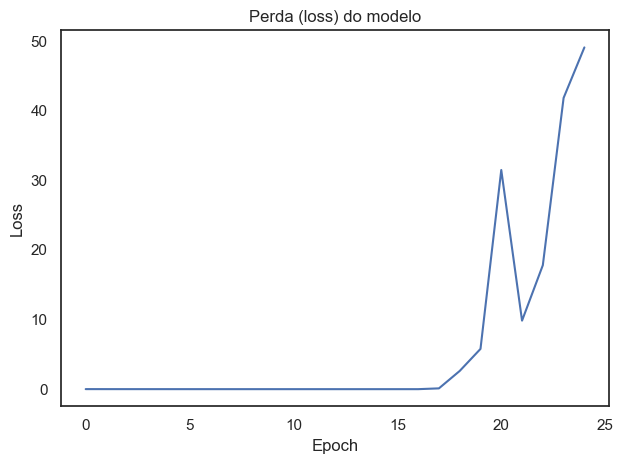

In [18]:
# Gráfico de perda
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Perda (loss) do modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Treino', 'Validação'], loc='upper right')

plt.tight_layout()

#### **Avaliando o modelo**

In [19]:
# Fazendo previsões
y_pred_norm = model.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

4610/4610 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [20]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': -5.837487462971808, 'MSE': 8.708917425555184, 'RMSE': 2.951087498796873}

### **Modelo LSTM com as variáveis selecionadas**

#### **Separação dos dados em teste e treino**

In [21]:
X = df[["Amina Flow", "Ore Pulp pH", "Flotation Column 01 Air Flow",
        "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow", "Flotation Column 04 Level", 
        "Flotation Column 05 Level", "Flotation Column 06 Level", "Flotation Column 07 Level",
        "% Iron Concentrate"]].copy()
y = df['% Silica Concentrate']

In [22]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [23]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [24]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [25]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [26]:
def objective(trial):    
    ## LSTM ##
    # units
    units = trial.suggest_categorical('units', [8, 16, 32, 64, 128])

    # kernel_initializer
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ["RandomNormal", "RandomUniform", "Zeros", "Ones", "GlorotNormal", "GlorotUniform"])

    # activation
    activation_lstm = trial.suggest_categorical('activation_lstm', ["relu", "linear", "sigmoid", "tanh"])

    ## Dropout ##
    # rate
    rate = trial.suggest_float('rate', 0.0001, 1)
    
    ## Dense ##
    # activation
    activation_dense = trial.suggest_categorical('activation_dense', ["relu", "linear", "sigmoid", "tanh"])

    # Instanciando o modelo
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units, kernel_initializer=kernel_initializer, activation=activation_lstm))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(units=1, activation=activation_dense))
    model.compile(loss="mse", optimizer="adam")

    # Treinando o modelo
    model.fit(X_train, y_train_norm, validation_split=0.1, batch_size=16, epochs=10)

    # Melhor MSE
    mse = model.evaluate(X_train, y_train_norm)
    
    return mse

In [27]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2024-10-14 11:42:55,930] A new study created in memory with name: no-name-09b673ea-1309-4e99-9496-b641ec9c3170


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0620 - val_loss: 0.0219
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0282 - val_loss: 0.0192
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0262 - val_loss: 0.0174
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0248 - val_loss: 0.0165
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0245 - val_loss: 0.0174
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0241 - val_loss: 0.0174
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0242 - val_loss: 0.0169
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0239 - val_loss: 0.0163
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0239 - val_loss: 0.0171
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0237 - val_loss: 0.0160
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 15s 818us/step - loss: 0.0160


[I 2024-10-14 11:52:40,818] Trial 0 finished with value: 0.016054397448897362 and parameters: {'units': 16, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'sigmoid', 'rate': 0.6705004634273843, 'activation_dense': 'linear'}. Best is trial 0 with value: 0.016054397448897362.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0241 - val_loss: 0.0162
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0175 - val_loss: 0.0159
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0170 - val_loss: 0.0152
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0163 - val_loss: 0.0145
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0155 - val_loss: 0.0139
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0149 - val_loss: 0.0134
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0146 - val_loss: 0.0130
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 15s 785us/step - loss: 0.0129


[I 2024-10-14 12:02:12,517] Trial 1 finished with value: 0.012959853745996952 and parameters: {'units': 16, 'kernel_initializer': 'RandomNormal', 'activation_lstm': 'linear', 'rate': 0.31558407944296235, 'activation_dense': 'linear'}. Best is trial 1 with value: 0.012959853745996952.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0258 - val_loss: 0.0167
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0177 - val_loss: 0.0163
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0165 - val_loss: 0.0153
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.0151 - val_loss: 0.0143
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 13s 713us/step - loss: 0.0143


[I 2024-10-14 12:11:23,614] Trial 2 finished with value: 0.014305613934993744 and parameters: {'units': 8, 'kernel_initializer': 'RandomUniform', 'activation_lstm': 'relu', 'rate': 0.05345720886256868, 'activation_dense': 'tanh'}. Best is trial 1 with value: 0.012959853745996952.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0303 - val_loss: 0.0169
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0183 - val_loss: 0.0157
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0171 - val_loss: 0.0149
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0153 - val_loss: 0.0138
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0150 - val_loss: 0.0135
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0149 - val_loss: 0.0143
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 17s 916us/step - loss: 0.0142


[I 2024-10-14 12:21:52,687] Trial 3 finished with value: 0.014284239150583744 and parameters: {'units': 32, 'kernel_initializer': 'Ones', 'activation_lstm': 'sigmoid', 'rate': 0.16543766169722107, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.012959853745996952.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.1744 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1745 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1739 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1745 - val_loss: 0.1753
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1743 - val_loss: 0.1753
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1743 - val_loss: 0.1753
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1748 - val_loss: 0.1753
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 15s 807us/step - loss: 0.1745


[I 2024-10-14 12:31:48,536] Trial 4 finished with value: 0.17466941475868225 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2371032775450034, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.012959853745996952.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.0229 - val_loss: 0.0157
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0170 - val_loss: 0.0146
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 115s 3ms/step - loss: 0.0157 - val_loss: 0.0137
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 123s 4ms/step - loss: 0.0149 - val_loss: 0.0130
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: 0.0145 - val_loss: 0.0129
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 0.0140 - val_loss: 0.0127
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 127s 4ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.0125 - val_loss: 0.0110
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0109


[I 2024-10-14 12:52:47,848] Trial 5 finished with value: 0.01094302348792553 and parameters: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'}. Best is trial 5 with value: 0.01094302348792553.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 0.0532 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 132s 4ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 0.0523 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 136s 4ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.0521 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0520


[I 2024-10-14 13:15:33,501] Trial 6 finished with value: 0.05205404385924339 and parameters: {'units': 128, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2330509764136363, 'activation_dense': 'sigmoid'}. Best is trial 5 with value: 0.01094302348792553.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0532 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0521 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 16s 874us/step - loss: 0.0520


[I 2024-10-14 13:27:14,648] Trial 7 finished with value: 0.052069440484046936 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.7438514714896854, 'activation_dense': 'sigmoid'}. Best is trial 5 with value: 0.01094302348792553.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.1533 - val_loss: 0.0188
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.0228 - val_loss: 0.0161
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.0200 - val_loss: 0.0145
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.0192 - val_loss: 0.0141
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.0186 - val_loss: 0.0139
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0180 - val_loss: 0.0135
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0177 - val_loss: 0.0128
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.0175 - val_loss: 0.0130
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.0172 - val_loss: 0.0128
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 0.0170 - val_loss: 0.0127
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 0.0126


[I 2024-10-14 13:41:03,833] Trial 8 finished with value: 0.012668648734688759 and parameters: {'units': 64, 'kernel_initializer': 'Ones', 'activation_lstm': 'relu', 'rate': 0.7453598974634115, 'activation_dense': 'relu'}. Best is trial 5 with value: 0.01094302348792553.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.0368 - val_loss: 0.0179
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0255 - val_loss: 0.0170
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0248 - val_loss: 0.0162
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0246 - val_loss: 0.0161
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.0243 - val_loss: 0.0161
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.0243 - val_loss: 0.0159
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0240 - val_loss: 0.0157
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0239 - val_loss: 0.0153
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0239 - val_loss: 0.0156
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0238 - val_loss: 0.0156
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 18s 978us/step - loss: 0.0156


[I 2024-10-14 13:52:36,441] Trial 9 finished with value: 0.015648677945137024 and parameters: {'units': 32, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'tanh', 'rate': 0.9319788719899176, 'activation_dense': 'tanh'}. Best is trial 5 with value: 0.01094302348792553.


In [28]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.01094302348792553
Melhores parâmetros: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'}


#### **Treinando o modelo com os parâmetros ajustados:**

In [29]:
# Instanciando o modelo
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=melhores_parametros['units'], kernel_initializer=melhores_parametros['kernel_initializer'], activation=melhores_parametros['activation_lstm']))
model.add(Dropout(rate=melhores_parametros['rate']))
model.add(Flatten())
model.add(Dense(units=1, activation=melhores_parametros['activation_dense']))
model.compile(loss="mse", optimizer="adam")

In [30]:
# Treinando o modelo
history = model.fit(X_train, y_train_norm, batch_size=16, epochs=25)

Epoch 1/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 121s 3ms/step - loss: 0.0221
Epoch 2/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 115s 3ms/step - loss: 0.0166
Epoch 3/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0154
Epoch 4/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - loss: 0.0146
Epoch 5/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 117s 3ms/step - loss: 0.0141
Epoch 6/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - loss: 0.0137
Epoch 7/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 118s 3ms/step - loss: 0.0132
Epoch 8/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - loss: 0.0130
Epoch 9/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - loss: 0.0126
Epoch 10/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - loss: 0.0123
Epoch 11/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 118s 3ms/step - loss: 0.0120
Epoch 12/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 117s 3ms/step - loss: 0.0118
Epoch 13/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - loss: 0.0117
Epoch 14/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 11

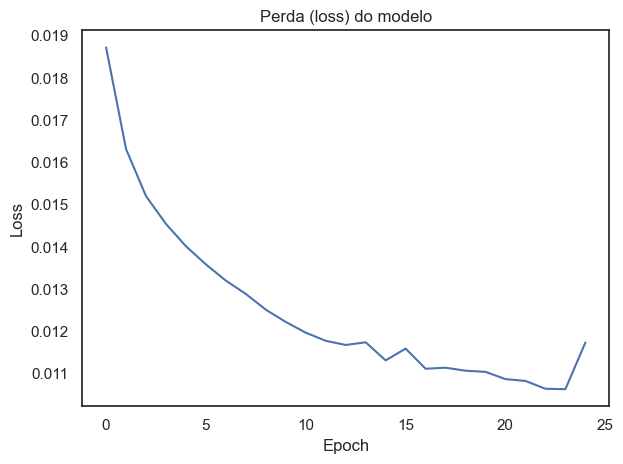

In [31]:
# Gráfico de perda
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Perda (loss) do modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Treino', 'Validação'], loc='upper right')

plt.tight_layout()

#### **Avaliando o modelo**

In [32]:
# Fazendo previsões
y_pred_norm = model.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

4610/4610 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [33]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.8248896670228095,
 'MSE': 0.22303827809828233,
 'RMSE': 0.47226928557580616}

### **Modelo LSTM com todas as variáveis, mas excluindo a variável % Iron Concentrate**

#### **Separação dos dados em teste e treino**

In [34]:
X = df.drop(columns=['% Iron Concentrate', '% Silica Concentrate'])
y = df['% Silica Concentrate']

In [35]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [36]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [37]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [38]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [39]:
def objective(trial):    
    ## LSTM ##
    # units
    units = trial.suggest_categorical('units', [8, 16, 32, 64, 128])

    # kernel_initializer
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ["RandomNormal", "RandomUniform", "Zeros", "Ones", "GlorotNormal", "GlorotUniform"])

    # activation
    activation_lstm = trial.suggest_categorical('activation_lstm', ["relu", "linear", "sigmoid", "tanh"])

    ## Dropout ##
    # rate
    rate = trial.suggest_float('rate', 0.0001, 1)
    
    ## Dense ##
    # activation
    activation_dense = trial.suggest_categorical('activation_dense', ["relu", "linear", "sigmoid", "tanh"])

    # Instanciando o modelo
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units, kernel_initializer=kernel_initializer, activation=activation_lstm))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(units=1, activation=activation_dense))
    model.compile(loss="mse", optimizer="adam")

    # Treinando o modelo
    model.fit(X_train, y_train_norm, validation_split=0.1, batch_size=16, epochs=10)

    # Melhor MSE
    mse = model.evaluate(X_train, y_train_norm)
    
    return mse

In [40]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2024-10-14 14:41:17,063] A new study created in memory with name: no-name-a3477afc-ab0a-4f71-9781-ceed7d40611f


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0747 - val_loss: 0.0500
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0508 - val_loss: 0.0497
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0505 - val_loss: 0.0494
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - loss: 0.0500 - val_loss: 0.0495
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0500 - val_loss: 0.0486
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0495 - val_loss: 0.0483
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0489 - val_loss: 0.0478
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0487 - val_loss: 0.0470
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - loss: 0.0484 - val_loss: 0.0471
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0482 - val_loss: 0.0464
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 0.0463


[I 2024-10-14 14:57:10,246] Trial 0 finished with value: 0.04643022269010544 and parameters: {'units': 16, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'sigmoid', 'rate': 0.6705004634273843, 'activation_dense': 'linear'}. Best is trial 0 with value: 0.04643022269010544.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0506 - val_loss: 0.0460
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.0459 - val_loss: 0.0439
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0437 - val_loss: 0.0413
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0412 - val_loss: 0.0388
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.0398 - val_loss: 0.0372
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0385 - val_loss: 0.0362
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0373 - val_loss: 0.0353
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0364 - val_loss: 0.0348
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0357 - val_loss: 0.0338
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0351 - val_loss: 0.0330
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 0.0327


[I 2024-10-14 15:13:01,179] Trial 1 finished with value: 0.032844360917806625 and parameters: {'units': 16, 'kernel_initializer': 'RandomNormal', 'activation_lstm': 'linear', 'rate': 0.31558407944296235, 'activation_dense': 'linear'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.0514 - val_loss: 0.0487
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.0491 - val_loss: 0.0485
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.0491 - val_loss: 0.0482
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0488 - val_loss: 0.0478
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - loss: 0.0483 - val_loss: 0.0474
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0478 - val_loss: 0.0469
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 0.0475 - val_loss: 0.0469
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0474 - val_loss: 0.0465
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0470 - val_loss: 0.0462
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.0468 - val_loss: 0.0462
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0461


[I 2024-10-14 15:28:55,486] Trial 2 finished with value: 0.04624248668551445 and parameters: {'units': 8, 'kernel_initializer': 'RandomUniform', 'activation_lstm': 'relu', 'rate': 0.05345720886256868, 'activation_dense': 'tanh'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - loss: 0.0578 - val_loss: 0.0489
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step - loss: 0.0490 - val_loss: 0.0485
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.0478 - val_loss: 0.0466
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0458 - val_loss: 0.0437
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0443 - val_loss: 0.0441
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.0437 - val_loss: 0.0423
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - loss: 0.0432 - val_loss: 0.0419
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0426 - val_loss: 0.0423
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0426 - val_loss: 0.0408
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0416 - val_loss: 0.0400
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.0400


[I 2024-10-14 15:47:40,448] Trial 3 finished with value: 0.04009569436311722 and parameters: {'units': 32, 'kernel_initializer': 'Ones', 'activation_lstm': 'sigmoid', 'rate': 0.16543766169722107, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - loss: 0.1751 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.1745 - val_loss: 0.1753
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.1749 - val_loss: 0.1753
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.1742 - val_loss: 0.1753
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - loss: 0.1746 - val_loss: 0.1753
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - loss: 0.1748 - val_loss: 0.1753
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - loss: 0.1741 - val_loss: 0.1753
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 0.1747 - val_loss: 0.1753
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 17s 944us/step - loss: 0.1745


[I 2024-10-14 16:03:11,297] Trial 4 finished with value: 0.17466941475868225 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2371032775450034, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - loss: 0.0497 - val_loss: 0.0406
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 209s 6ms/step - loss: 0.0407 - val_loss: 0.0418
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: 0.0405 - val_loss: 0.0467
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - loss: 66582269952.0000 - val_loss: 13138107392.0000
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 189s 6ms/step - loss: 373976858624.0000 - val_loss: 16851420160.0000
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - loss: nan - val_loss: nan
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 185s 6ms/step - loss: nan - val_loss: nan
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - loss: nan - val_loss: nan
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - loss: nan - val_loss: nan
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 186s 6ms/step - loss: nan - val_loss: nan
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: nan


[W 2024-10-14 16:36:10,119] Trial 5 failed with parameters: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'} because of the following error: The value nan is not acceptable.
[W 2024-10-14 16:36:10,119] Trial 5 failed with value nan.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0530 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 190s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - loss: 0.0519 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0519 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 189s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 0.0519 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - loss: 0.0520


[I 2024-10-14 17:08:56,177] Trial 6 finished with value: 0.05205363407731056 and parameters: {'units': 128, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2330509764136363, 'activation_dense': 'sigmoid'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0532 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms/step - loss: 0.0521 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 18s 972us/step - loss: 0.0520


[I 2024-10-14 17:23:56,143] Trial 7 finished with value: 0.05206838995218277 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.7438514714896854, 'activation_dense': 'sigmoid'}. Best is trial 1 with value: 0.032844360917806625.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step - loss: 0.4724 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 5.2057 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.1076 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step - loss: 0.1020 - val_loss: 0.0404
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 0.0424 - val_loss: 0.0354
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - loss: 0.0385 - val_loss: 0.0335
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 126s 4ms/step - loss: 0.0367 - val_loss: 0.0334
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step - loss: 0.0351 - val_loss: 0.0317
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 131s 4ms/step - loss: 0.0341 - val_loss: 0.0308
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step - loss: 0.0331 - val_loss: 0.0285
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0283


[I 2024-10-14 17:45:40,922] Trial 8 finished with value: 0.02844635769724846 and parameters: {'units': 64, 'kernel_initializer': 'Ones', 'activation_lstm': 'relu', 'rate': 0.7453598974634115, 'activation_dense': 'relu'}. Best is trial 8 with value: 0.02844635769724846.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0541 - val_loss: 0.0478
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - loss: 0.0486 - val_loss: 0.0464
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - loss: 0.0467 - val_loss: 0.0420
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - loss: 0.0449 - val_loss: 0.0404
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0438 - val_loss: 0.0396
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0432 - val_loss: 0.0380
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0420 - val_loss: 0.0371
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0413 - val_loss: 0.0368
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0405 - val_loss: 0.0354
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0397 - val_loss: 0.0341
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.0340


[I 2024-10-14 18:03:31,229] Trial 9 finished with value: 0.034112878143787384 and parameters: {'units': 32, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'tanh', 'rate': 0.9319788719899176, 'activation_dense': 'tanh'}. Best is trial 8 with value: 0.02844635769724846.


In [41]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.02844635769724846
Melhores parâmetros: {'units': 64, 'kernel_initializer': 'Ones', 'activation_lstm': 'relu', 'rate': 0.7453598974634115, 'activation_dense': 'relu'}


#### **Treinando o modelo com os parâmetros ajustados:**

In [42]:
# Instanciando o modelo
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=melhores_parametros['units'], kernel_initializer=melhores_parametros['kernel_initializer'], activation=melhores_parametros['activation_lstm']))
model.add(Dropout(rate=melhores_parametros['rate']))
model.add(Flatten())
model.add(Dense(units=1, activation=melhores_parametros['activation_dense']))
model.compile(loss="mse", optimizer="adam")

In [43]:
# Treinando o modelo
history = model.fit(X_train, y_train_norm, batch_size=16, epochs=25)

Epoch 1/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 125s 3ms/step - loss: 0.1606
Epoch 2/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - loss: 0.1394
Epoch 3/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1366
Epoch 4/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1366
Epoch 5/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1370
Epoch 6/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1367
Epoch 7/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1371
Epoch 8/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1367
Epoch 9/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1363
Epoch 10/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - loss: 0.1371
Epoch 11/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - loss: 0.1365
Epoch 12/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - loss: 0.1373
Epoch 13/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 123s 3ms/step - loss: 0.1370
Epoch 14/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 12

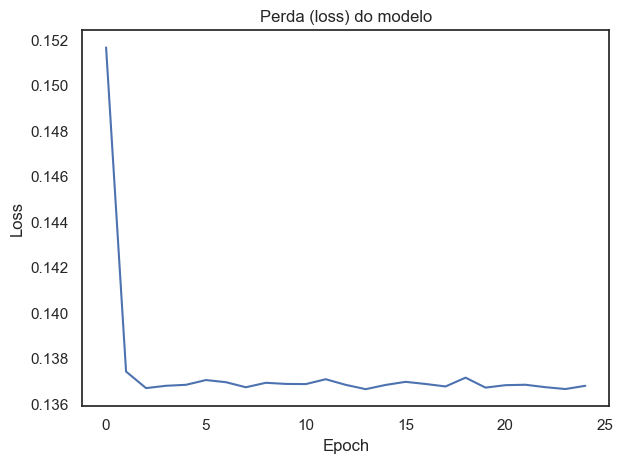

In [44]:
# Gráfico de perda
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Perda (loss) do modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Treino', 'Validação'], loc='upper right')

plt.tight_layout()

#### **Avaliando o modelo**

In [45]:
# Fazendo previsões
y_pred_norm = model.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

4610/4610 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [46]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': -2.345850493010006, 'MSE': 4.261614492118213, 'RMSE': 2.064367818998885}

### **Modelo LSTM com as variáveis selecionadas, mas excluindo a variável % Iron Concentrate**

#### **Separação dos dados em teste e treino**

In [8]:
X = df[["Amina Flow", "Ore Pulp pH", "Flotation Column 01 Air Flow",
        "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow", "Flotation Column 04 Level", 
        "Flotation Column 05 Level", "Flotation Column 06 Level", "Flotation Column 07 Level"]].copy()
y = df['% Silica Concentrate']

In [9]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [10]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [11]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [12]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [13]:
def objective(trial):    
    ## LSTM ##
    # units
    units = trial.suggest_categorical('units', [8, 16, 32, 64, 128])

    # kernel_initializer
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ["RandomNormal", "RandomUniform", "Zeros", "Ones", "GlorotNormal", "GlorotUniform"])

    # activation
    activation_lstm = trial.suggest_categorical('activation_lstm', ["relu", "linear", "sigmoid", "tanh"])

    ## Dropout ##
    # rate
    rate = trial.suggest_float('rate', 0.0001, 1)
    
    ## Dense ##
    # activation
    activation_dense = trial.suggest_categorical('activation_dense', ["relu", "linear", "sigmoid", "tanh"])

    # Instanciando o modelo
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units, kernel_initializer=kernel_initializer, activation=activation_lstm))
    model.add(Dropout(rate=rate))
    model.add(Flatten())
    model.add(Dense(units=1, activation=activation_dense))
    model.compile(loss="mse", optimizer="adam")

    # Treinando o modelo
    model.fit(X_train, y_train_norm, validation_split=0.1, batch_size=16, epochs=10)

    # Melhor MSE
    mse = model.evaluate(X_train, y_train_norm)
    
    return mse

In [14]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2024-10-15 07:34:42,178] A new study created in memory with name: no-name-42ce4756-964a-4bd5-8beb-963bb97fba10


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0691 - val_loss: 0.0480
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0488 - val_loss: 0.0463
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0473 - val_loss: 0.0457
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0468 - val_loss: 0.0450
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0468 - val_loss: 0.0452
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0468 - val_loss: 0.0453
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0466 - val_loss: 0.0450
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0467 - val_loss: 0.0464
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0465 - val_loss: 0.0455
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0465 - val_loss: 0.0445
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 17s 933us/step - loss: 0.0445


[I 2024-10-15 07:44:55,937] Trial 0 finished with value: 0.044615745544433594 and parameters: {'units': 16, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'sigmoid', 'rate': 0.6705004634273843, 'activation_dense': 'linear'}. Best is trial 0 with value: 0.044615745544433594.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.0494 - val_loss: 0.0451
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0455 - val_loss: 0.0436
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0442 - val_loss: 0.0430
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0437 - val_loss: 0.0426
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0430 - val_loss: 0.0418
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0426 - val_loss: 0.0415
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0420 - val_loss: 0.0407
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0416 - val_loss: 0.0408
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0414 - val_loss: 0.0407
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.0412 - val_loss: 0.0397
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 15s 819us/step - loss: 0.0395


[I 2024-10-15 07:54:54,676] Trial 1 finished with value: 0.03967241942882538 and parameters: {'units': 16, 'kernel_initializer': 'RandomNormal', 'activation_lstm': 'linear', 'rate': 0.31558407944296235, 'activation_dense': 'linear'}. Best is trial 1 with value: 0.03967241942882538.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0500 - val_loss: 0.0450
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0454 - val_loss: 0.0447
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0449 - val_loss: 0.0442
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0447 - val_loss: 0.0438
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0444 - val_loss: 0.0436
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0441 - val_loss: 0.0432
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.0438 - val_loss: 0.0429
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0436 - val_loss: 0.0429
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.0432 - val_loss: 0.0427
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0430 - val_loss: 0.0429
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 14s 735us/step - loss: 0.0428


[I 2024-10-15 08:04:40,778] Trial 2 finished with value: 0.04292338341474533 and parameters: {'units': 8, 'kernel_initializer': 'RandomUniform', 'activation_lstm': 'relu', 'rate': 0.05345720886256868, 'activation_dense': 'tanh'}. Best is trial 1 with value: 0.03967241942882538.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.0574 - val_loss: 0.0462
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0461 - val_loss: 0.0451
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0458 - val_loss: 0.0449
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0454 - val_loss: 0.0460
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0450 - val_loss: 0.0443
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0443 - val_loss: 0.0447
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.0442 - val_loss: 0.0432
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - loss: 0.0440 - val_loss: 0.0435
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0435 - val_loss: 0.0428
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 18s 954us/step - loss: 0.0427


[I 2024-10-15 08:14:56,479] Trial 3 finished with value: 0.04283871129155159 and parameters: {'units': 32, 'kernel_initializer': 'Ones', 'activation_lstm': 'sigmoid', 'rate': 0.16543766169722107, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.03967241942882538.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.1745 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.1750 - val_loss: 0.1753
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.1752 - val_loss: 0.1753
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.1744 - val_loss: 0.1753
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.1745 - val_loss: 0.1753
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 0.1747 - val_loss: 0.1753
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.1743 - val_loss: 0.1753
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.1745 - val_loss: 0.1753
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 13s 718us/step - loss: 0.1745


[I 2024-10-15 08:24:13,691] Trial 4 finished with value: 0.17466941475868225 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2371032775450034, 'activation_dense': 'relu'}. Best is trial 1 with value: 0.03967241942882538.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 0.0488 - val_loss: 0.0435
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 0.0443 - val_loss: 0.0428
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 0.0426 - val_loss: 0.0411
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step - loss: 0.0417 - val_loss: 0.0401
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step - loss: 0.0408 - val_loss: 0.0394
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0400 - val_loss: 0.0391
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 0.0397 - val_loss: 0.0383
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 0.0391 - val_loss: 0.0380
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step - loss: 0.5497 - val_loss: 0.0377
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 116s 3ms/step - loss: 0.0388 - val_loss: 0.0371
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0371


[I 2024-10-15 08:42:04,745] Trial 5 finished with value: 0.037255655974149704 and parameters: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'}. Best is trial 5 with value: 0.037255655974149704.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step - loss: 0.0531 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.0519 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 0.0519 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0520


[I 2024-10-15 09:01:04,359] Trial 6 finished with value: 0.05206392705440521 and parameters: {'units': 128, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.2330509764136363, 'activation_dense': 'sigmoid'}. Best is trial 5 with value: 0.037255655974149704.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0531 - val_loss: 0.0520
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0520 - val_loss: 0.0520
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0521 - val_loss: 0.0520
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.0520 - val_loss: 0.0520
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 14s 741us/step - loss: 0.0520


[I 2024-10-15 09:10:32,171] Trial 7 finished with value: 0.05205368250608444 and parameters: {'units': 8, 'kernel_initializer': 'Zeros', 'activation_lstm': 'relu', 'rate': 0.7438514714896854, 'activation_dense': 'sigmoid'}. Best is trial 5 with value: 0.037255655974149704.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.1533 - val_loss: 0.1753
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.0785 - val_loss: 0.1753
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.0774 - val_loss: 0.1752
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.0766 - val_loss: 0.1745
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.0766 - val_loss: 0.1739
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 0.0670 - val_loss: 0.0410
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.0419 - val_loss: 0.0400
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.0416 - val_loss: 0.0402
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - loss: 0.0411 - val_loss: 0.0392
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 0.0410 - val_loss: 0.0389
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0389


[I 2024-10-15 09:23:06,709] Trial 8 finished with value: 0.03901035711169243 and parameters: {'units': 64, 'kernel_initializer': 'Ones', 'activation_lstm': 'relu', 'rate': 0.7453598974634115, 'activation_dense': 'relu'}. Best is trial 5 with value: 0.037255655974149704.


Epoch 1/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.0519 - val_loss: 0.0466
Epoch 2/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - loss: 0.0480 - val_loss: 0.0460
Epoch 3/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.0475 - val_loss: 0.0451
Epoch 4/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - loss: 0.0471 - val_loss: 0.0450
Epoch 5/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 0.0468 - val_loss: 0.0448
Epoch 6/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.0466 - val_loss: 0.0450
Epoch 7/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - loss: 0.0465 - val_loss: 0.0443
Epoch 8/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0462 - val_loss: 0.0443
Epoch 9/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0462 - val_loss: 0.0443
Epoch 10/10
33186/33186 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 0.0461 - val_loss: 0.0436
18437/18437 ━━━━━━━━━━━━━━━━━━━━ 16s 862us/step - loss: 0.0436


[I 2024-10-15 09:33:29,810] Trial 9 finished with value: 0.04366851598024368 and parameters: {'units': 32, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'tanh', 'rate': 0.9319788719899176, 'activation_dense': 'tanh'}. Best is trial 5 with value: 0.037255655974149704.


In [15]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.037255655974149704
Melhores parâmetros: {'units': 128, 'kernel_initializer': 'GlorotNormal', 'activation_lstm': 'linear', 'rate': 0.7554875062972062, 'activation_dense': 'linear'}


#### **Treinando o modelo com os parâmetros ajustados:**

In [16]:
# Instanciando o modelo
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=melhores_parametros['units'], kernel_initializer=melhores_parametros['kernel_initializer'], activation=melhores_parametros['activation_lstm']))
model.add(Dropout(rate=melhores_parametros['rate']))
model.add(Flatten())
model.add(Dense(units=1, activation=melhores_parametros['activation_dense']))
model.compile(loss="mse", optimizer="adam")

In [17]:
# Treinando o modelo
history = model.fit(X_train, y_train_norm, batch_size=16, epochs=25)

Epoch 1/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.0483
Epoch 2/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 0.0441
Epoch 3/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - loss: 0.0427
Epoch 4/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.0415
Epoch 5/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0406
Epoch 6/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0399
Epoch 7/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.1077
Epoch 8/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0391
Epoch 9/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0384
Epoch 10/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.0383
Epoch 11/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0377
Epoch 12/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 0.0379
Epoch 13/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 0.0395
Epoch 14/25
36873/36873 ━━━━━━━━━━━━━━━━━━━━ 101s 3ms

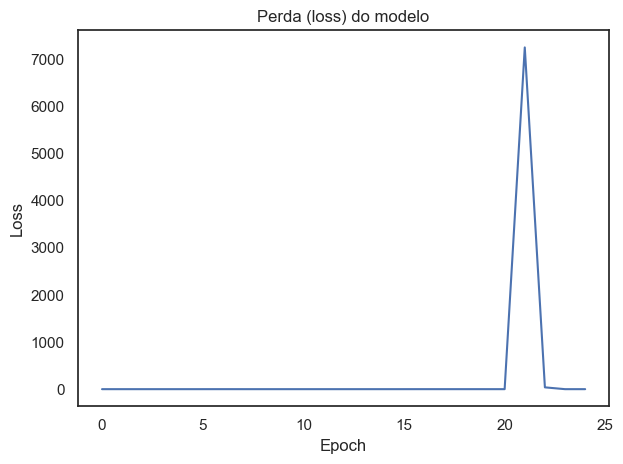

In [18]:
# Gráfico de perda
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Perda (loss) do modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Treino', 'Validação'], loc='upper right')

plt.tight_layout()

#### **Avaliando o modelo**

In [19]:
# Fazendo previsões
y_pred_norm = model.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

4610/4610 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [20]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.31093992178819263,
 'MSE': 0.8776567935065726,
 'RMSE': 0.9368333862040638}